# Measuring Spectral Bias with Kernels

(Note: this experiment ran reasonably fast on a workstation with 20 physical cores, 256 GB RAM and 2x NVIDIA 1080Ti GPUs. That said, if you have a smaller machine, it should probably still work.)

The fun begins at **Play**. 

If you wish to run the notebook, this is all you'll need:

In [16]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets

from argparse import Namespace

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
sns.set()
%matplotlib inline

## Data Logistics

This will download MNIST when run for the first time. 

In [12]:
def make_mnist(opt):
    if opt.FMNIST:
        mnist = datasets.FashionMNIST('../fmnist', download=True)
    else:
        mnist = datasets.MNIST('..', download=True)
    X = mnist.train_data.float().div_(255.)
    X = X.view(X.shape[0], 784)
    Y = torch.zeros((X.shape[0], 10), dtype=X.dtype, device=X.device)
    Y[list(range(X.shape[0])), mnist.train_labels] = 1.
    if opt.MASK_CLASSES is not None: 
        mask = (mnist.train_labels.eq(opt.MASK_CLASSES[0]) + mnist.train_labels.eq(opt.MASK_CLASSES[1])).gt(0)
        X = X[mask]
        Y = Y[mask]
    if opt.DATASET_SIZE is not None: 
        X, Y = X[0:opt.DATASET_SIZE], Y[0:opt.DATASET_SIZE]
    return X, Y

def binarize_mnist(opt, X, Y):
    if opt.MASK_CLASSES is not None:
        Y[:, opt.MASK_CLASSES[0]] *= -1
        Y = Y.sum(-1)
    return X, Y

def get_mnist(opt, val=False, noise_train=True): 
    X, Y = make_mnist(opt)
    X, Y = binarize_mnist(opt, X, Y)
    if not val: 
        stop = int(opt.VAL_SPLIT * X.shape[0])
        X = X[:stop]
        Y = Y[:stop]
        if noise_train:
            X, Y = noise_labels(opt, X, Y)
    else:
        start = int(opt.VAL_SPLIT * X.shape[0])
        X = X[start:]
        Y = Y[start:]
    return X, Y

## Kernels

In [204]:
def rbf_kernel(opt, x_sub_y): 
    gamma = 0.5/opt.KERNEL_WIDTH ** 2
    return torch.exp(-gamma * x_sub_y.pow(2))

def compute_kernel(opt, X, X_is_gram=False): 
    assert len(X.shape) == 2
    if X_is_gram: 
        gram = X
    else:
        gram = compute_gram(opt, X)
    kernel = rbf_kernel(opt, gram)
    return kernel

def compute_gram(opt, X):
    if opt.VECTORIZED_KERNEL:
        gram = torch.norm(X[None, :] - X[:, None], dim=-1)
    else: 
        gram = torch.zeros((X.shape[0], X.shape[0]))
        for idx in range(X.shape[0]): 
            if idx % (X.shape[0]/100) == 0: 
                print(">", end='')
            x = X[idx:idx+1]
            x_norm = torch.norm(x[None, :] - X[:, None], dim=-1)
            gram[idx] = x_norm.squeeze()    
    return gram

def compute_weight(opt, kernel, labels):
    # Regularize kernel
    reg_kern = kernel + opt.REG_LAMBDA * torch.eye(kernel.shape[0])
    weight = reg_kern.inverse() @ labels
    return weight

def linear_forward(opt, kernel, weight):
    return kernel @ weight

def _reverse(x, dim=0): 
    if dim == 0: 
        return x[list(reversed(list(range(x.shape[0]))))]
    else:
        assert dim == 1
        return x[:, list(reversed(list(range(x.shape[0]))))]

def spectrum(opt, kernel, fvals, return_eigen=False): 
    # Eval eigvecs
    eigvals, eigvecs = torch.symeig(kernel, eigenvectors=True)
    # Reverse spectrum (torch sorts eigenvalues in increasing order, we 
    # need it in decreasing order.)
    eigvals = _reverse(eigvals, 0)
    eigvecs = _reverse(eigvecs, 1)
    # Evaluate spectrum
    spec = eigvecs.t() @ fvals
    if return_eigen: 
        return spec, (eigvals, eigvecs)
    else:
        return spec
    
def spectrum_from_eigvecs(opt, eigvecs, fvals): 
    return eigvecs.t() @ fvals

def inv_eigtransform(eigvecs, spec):
    return (eigvecs * spec.view(1, -1)).sum(-1, keepdim=True)

def make_noise(opt, Y, eigvecs):
    if opt.TARGET_NOISE_MODE == 'white': 
        noise = Y.clone().uniform_(-1, 1)
    elif opt.TARGET_NOISE_MODE == 'hfn': 
        noise = inv_eigtransform(eigvecs, torch.linspace(0, 1, Y.shape[0]).pow(opt.TARGET_NOISE_BETA).to(eigvecs.device))
    else: 
        raise NotImplementedError
    return noise.reshape(*Y.shape)

def add_noise(opt, Y, eigvecs): 
    # Make noise 
    noise = make_noise(opt, Y, eigvecs)
    # Add noise to signal
    noised_Y = opt.TARGET_PURE_AMP * Y + opt.TARGET_NOISE_AMP * noise
    return noised_Y

## Model Training

In [4]:
def make_model(opt):
    layers = []
    layers.append(nn.Linear(opt.INP_DIM, opt.WIDTH))
    layers.append(nn.ReLU())
    for _ in range(opt.DEPTH - 2): 
        layers.append(nn.Linear(opt.WIDTH, opt.WIDTH))
        layers.append(nn.ReLU())
    layers.extend([nn.Linear(opt.WIDTH, opt.OUT_DIM)])
    model = nn.Sequential(*layers)
    if opt.CUDA:
        model = model.cuda()
    return model

In [48]:
def train_model(opt, model, input_, target, val_input_, val_target, spectrum_fn=None):
    # Build loss
    loss_fn = nn.MSELoss()
    # Build optim
    optim = torch.optim.Adam(model.parameters(), lr=opt.LR)
    # Rec
    frames = []
    model.train()
    # To cuda
    if opt.CUDA:
        input_ = input_.cuda()
        target = target.cuda()
        val_input_ = val_input_.cuda()
        val_target = val_target.cuda()
    # Loop! 
    for iter_num in range(opt.NUM_ITER):
        if iter_num % (opt.NUM_ITER // 100) == 0: 
            print(">", end='')
        x = input_
        yt = target.view(-1, opt.OUT_DIM)
        optim.zero_grad()
        y = model(x)
        loss = loss_fn(y, yt)
        loss.backward()
        optim.step()
        if iter_num % opt.REC_FRQ == 0: 
            # Evaluate spectrum 
            if spectrum_fn is not None: 
                with torch.no_grad(): 
                    spec = spectrum_fn(y).cpu()
            # Validate
            with torch.no_grad(): 
                x = val_input_
                yt = val_target.view(-1, opt.OUT_DIM)
                y = model(x)
                val_loss = loss_fn(y, yt)
                acc = y.squeeze().gt(0.).eq(yt.gt(0)).float().mean()
            frames.append(Namespace(iter_num=iter_num, 
                                    # prediction=y.data.cpu().numpy(), 
                                    loss=loss.item(), 
                                    accuracy=acc, 
                                    val_loss=val_loss.item(), 
                                    spectrum=spec))
    # Done
    model.eval()
    return frames

## Plotting

In [6]:
font = {'size'   : 30}

SIZE = 15

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=SIZE)
matplotlib.rc('ytick', labelsize=SIZE)
matplotlib.rc('axes', labelsize=SIZE, titlesize=SIZE)
matplotlib.rc('legend', fontsize=SIZE)

In [26]:
def plot_loss(frames): 
    its, val_loss, tr_loss = zip(*[(frame.iter_num, frame.val_loss, frame.loss) for frame in frames])
    plt.figure()
    plt.semilogy(its, tr_loss, label='Training')
    plt.semilogy(its, val_loss, label='Validation')
    plt.xlabel("Training Iteration")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()
    
def compare_loss(frames0, frames1): 
    its, val_loss0 = zip(*[(frame.iter_num, frame.val_loss) for frame in frames0])
    its, val_loss1 = zip(*[(frame.iter_num, frame.val_loss) for frame in frames1])
    plt.figure()
    plt.semilogy(its, val_loss0, label='Set 0')
    plt.semilogy(its, val_loss1, label='Set 1')
    plt.xlabel("Training Iteration")
    plt.ylabel("MSE Loss")
    plt.legend()
    plt.show()
    
def plot_gram_and_kernel(gram, kernel): 
    fig, (ax0, ax1) = plt.subplots(1, 2, sharey=True)
    ax0.set_title("Gramian")
    im0 = ax0.imshow(gram)
    ax0.grid(False)
    ax1.set_title("Kernel")
    im1 = ax1.imshow(kernel)
    ax1.grid(False)
    plt.show()

In [143]:
# This bins a vector and averages over the bins, kinda like 
# mean-pooling with non-overlapping window. 
def bin_mean(x, num_bins, bin_size):
    if len(x.shape) == 1: 
        return x.reshape(num_bins, bin_size).mean(-1)
    else:
        return x.reshape(-1, num_bins, bin_size).mean(-1)
    
def plot_spectrum(spec, smooth=False, num_bins=None, bin_size=None, 
                  show=True, norm_spec=None, label=None, color=None): 
    # Take absolute value of the spectrum
    spec = abs(spec)
    norm_spec = abs(norm_spec) if norm_spec is not None else None
    with torch.no_grad():
        if smooth:
            spec = bin_mean(spec, num_bins, bin_size)
            if norm_spec is not None: 
                norm_spec = bin_mean(norm_spec, num_bins, bin_size)
    # Normalize spectrum if required
    if norm_spec is not None: 
        spec = spec / norm_spec
    if show:
        plt.figure()
    if color is None: 
        plt.plot(spec.data.squeeze().cpu().numpy(), label=label)
    else:
        plt.plot(spec.data.squeeze().cpu().numpy(), label=label, c=color)
    if show:
        plt.ylabel("Spectrum" if norm_spec is None else "Normalized Spectrum")
        if smooth: 
            plt.xlabel(f"Eigenfunction Idx [/{bin_size}]")
        plt.show()

In [206]:
def plot_spectral_bias(frames, plot_at_iters, normalize=True, legend=True, 
                       plot_targets=False, normalize_with='target'): 
    LIGHT = 0.8
    DARK= 0.2
    norm_spec = ((frames[0].target_spectrum if normalize_with == 'target' else 
                  frames[0].pure_spectrum) 
                 if normalize else None)
    plt.figure()
    with sns.cubehelix_palette(len(plot_at_iters), light=0.8, dark=0.2):
        for iter_ in plot_at_iters: 
            plot_spectrum(frames[iter_].spectrum, True, 100, 20, False, 
                          norm_spec, f'Iteration {iter_}')
    if plot_targets: 
        cpal = sns.color_palette("RdBu_r", 7)
        plot_spectrum(frames[0].target_spectrum, True, 100, 20, False, 
                      norm_spec, "Noised Target", cpal[0])
        plot_spectrum(frames[0].pure_spectrum, True, 100, 20, False, 
                      norm_spec, "Pure Target", cpal[-1])
    if legend:
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("Eigenfunction Idx [/20]")
    plt.ylabel("Relative Coefficient" if normalize else "Absolute Coefficient")
    plt.show()
    
def plot_target_spectrum(frames): 
    plt.figure()
    plot_spectrum(frames[0].target_spectrum, True, 100, 20, False, label='Noised Target')
    plot_spectrum(frames[0].pure_spectrum, True, 100, 20, False, label='Pure Target')
    plt.xlabel("Eigenfunction Idx [/20]")
    plt.ylabel("Absolute Coefficients")
    plt.legend()
    plt.show()

In [40]:
font = {'size'   : 30}

SIZE = 15

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=SIZE)
matplotlib.rc('ytick', labelsize=SIZE)
matplotlib.rc('axes', labelsize=SIZE, titlesize=SIZE)
matplotlib.rc('legend', fontsize=SIZE)

## Play

In [10]:
opt = Namespace()

In [133]:
# Data Generation
opt.MASK_CLASSES = [3, 8]    # <--- Select a dataset, could be [0, 1], [3, 9], ...
opt.VAL_SPLIT = 1.0          # <--- What percent of data to use for training
opt.FMNIST = False           # <--- Whether to use Fashion-MNIST. 
opt.DATASET_SIZE = 2000      # <--- Size of the dataset subset to use. Big ==> download more RAM.
# Model Definition
opt.INP_DIM = 784            # <--- Input dim of the network. (leave this alone for (F)MNIST)
opt.OUT_DIM = 1              # <--- Number of network outputs. (leave this alone for (F)MNIST)
opt.DEPTH = 6                # <--- Depth of the network.
opt.WIDTH = 256              # <--- Width of layers. 
opt.CUDA = True              # <--- Whether to use CUDA
# Model Training
opt.LR = 0.0001              # <--- LR for the optimizer. 
opt.NUM_ITER = 5000          # <--- Number of training iterations
opt.REC_FRQ = 1              # <--- How often to record stats (leave this alone). 
# Kernel
opt.KERNEL_WIDTH = 1.25      # <--- Width (sigma) of the Gaussian RBF kernel for MNIST
opt.VECTORIZED_KERNEL = True # <--- Whether to compute the Gram matrix in one go (fast but rip ram). 
# Label
opt.TARGET_NOISE_MODE = 'white'  # <--- Specifies if the target should be ('white') noise or 
                                 #      if high-"frequency"-noise should be added to the true target ('hfn')
opt.TARGET_NOISE_BETA = 2        # <--- Applicable if TARGET_NOISE_MODE is 'hfn'. Specifies the profile of the 
                                 #      noise. 
opt.TARGET_NOISE_AMP = 1.
opt.TARGET_PURE_AMP = 1.

### Prepare Data and Compute the Kernel

In [15]:
X, Y = make_mnist(opt)
X, Y = binarize_mnist(opt, X, Y)

This might take a lot of RAM, depending on the dataset size. 

In [18]:
gram = compute_gram(opt, X)
kernel = compute_kernel(opt, gram, X_is_gram=True)

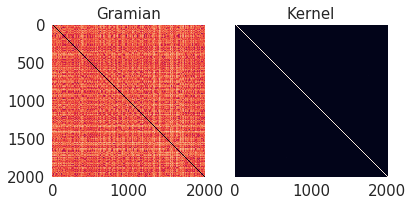

In [41]:
plot_gram_and_kernel(gram, kernel)

In [36]:
spec, (eigvals, eigvecs) = spectrum(opt, kernel, Y, return_eigen=True)

In [53]:
spectrum_fn = lambda y: spectrum_from_eigvecs(opt, eigvecs, y.cpu())

### Eigenvalues of the Kernel and Spectrum of the Target

The eigenvalues of the kernel are sorted in decreasing order:

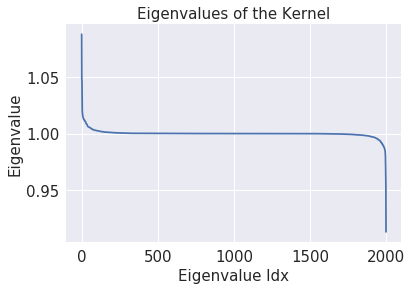

In [42]:
plt.figure()
plt.title("Eigenvalues of the Kernel")
plt.plot(eigvals.data.cpu().numpy())
plt.xlabel("Eigenvalue Idx")
plt.ylabel("Eigenvalue")
plt.show()

This is what the (smoothed) spectrum of the target looks like:

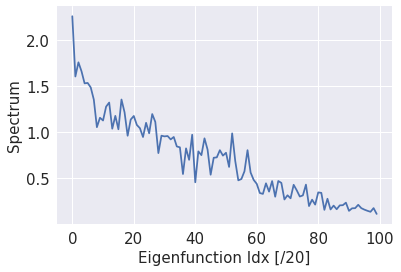

In [45]:
plot_spectrum(spec, True, 100, 20)

### Spectral Bias Experiments

In [132]:
def spectral_bias(opt): 
    model = make_model(opt)
    Y_noised = add_noise(opt, Y, eigvecs)
    frames = train_model(opt, model, X, Y_noised, X, Y, spectrum_fn)
    # Smuggle Y_noised out
    frames[0].target = Y_noised.data.cpu()
    with torch.no_grad():
        frames[0].target_spectrum = spectrum_fn(Y_noised).data.cpu()
        frames[0].pure_spectrum = spectrum_fn(Y).data.cpu()
    return frames

#### On Real Labels + White Noise

In this experiment, we fit a network to the true target $\tau_0$ + i.i.d random noise $\psi$ (white noise). The training target looks like: 

$$
\tau(\mathbf{x}) = \tau_0(\mathbf{x}) + \psi(\mathbf{x})
$$
Note that $\psi(\mathbf{x})$ is i.i.d for all $\mathbf{x}$.

In [190]:
opt.TARGET_NOISE_MODE = 'white'
opt.TARGET_NOISE_AMP = 1.
opt.TARGET_PURE_AMP = 1.
frames = spectral_bias(opt)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

Below, we plot the spectrum of the pure target $\tau_0$ and that of the noised target $\tau$. 

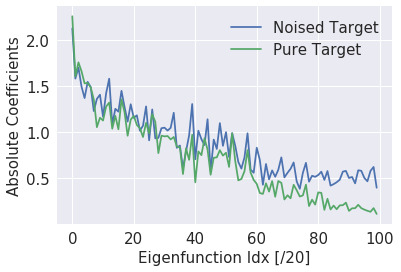

In [191]:
plt.figure()
plot_spectrum(frames[0].target_spectrum, True, 100, 20, False, label='Noised Target')
plot_spectrum(frames[0].pure_spectrum, True, 100, 20, False, label='Pure Target')
plt.xlabel("Eigenfunction Idx [/20]")
plt.ylabel("Absolute Coefficients")
plt.legend()
plt.show()

Now, let's plot the loss curve to find where the dip in validation loss is (validation loss is obtained from the pure target signal). 

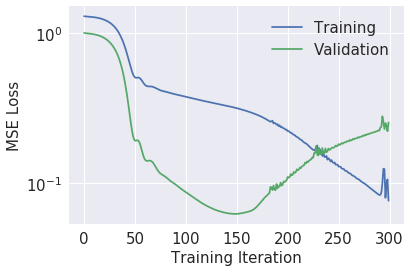

In [192]:
plot_loss(frames[0:300])

The dip appears to be around 150. Let's see what happens to the spectrum then. 

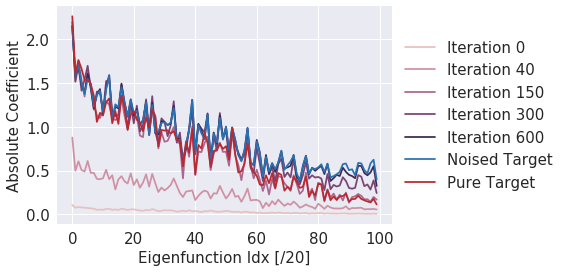

In [193]:
plot_spectral_bias(frames, [0, 40, 150, 300, 600], 
                   normalize=False, plot_targets=True)

What we find is that the pure target function with predominantly low-frequency components is learned at around iteration 150. The network spends the rest of the training trying to learn the higher frequency noise. Let's push this even further. 

#### On Real Labels + High-Frequency Noise

In this experiment, we add high-frequency eigenfunctions to the target, and investigate how the learning is affected. Unlike white-noise, which affects all frequencies equally (in expectation), high-frequency noise should only affect the higher frequencies.

In [205]:
opt.TARGET_NOISE_MODE = 'hfn'
opt.TARGET_NOISE_AMP = 1.
opt.TARGET_PURE_AMP = 1.
frames = spectral_bias(opt)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

It is indeed the case that mostly high-frequency components are affected. 

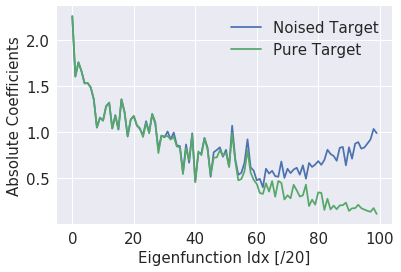

In [207]:
plot_target_spectrum(frames)

Observe that the best loss is lower than in the white-noise case. This is expected, because white noise also contains lower frequencies to which the network is sensitive to due to the spectral bias. 

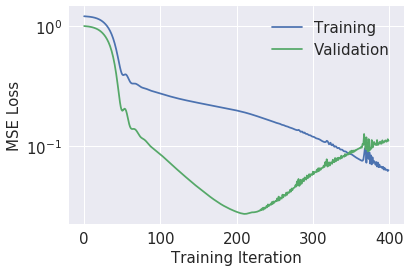

In [209]:
plot_loss(frames[0:400])

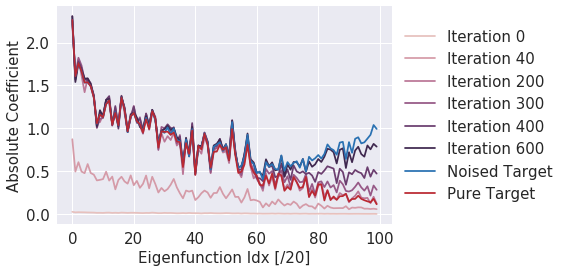

In [212]:
plot_spectral_bias(frames, [0, 40, 200, 300, 400, 600], 
                   normalize=False, plot_targets=True)

Due to spectral bias, that the network first learns the lower frequencies (around iteration 200). The remaining higher frequencies are gradually learned as the training progresses. 